In [14]:

import numpy as np
import pandas as pd
import os
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score



data_path = "/kaggle/input"

train_path ="train_data.txt"
test_path = "test_data.txt"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if "train" in filename.lower() and filename.endswith(".txt"):
            train_path = os.path.join(dirname, filename)
        if "test" in filename.lower() and filename.endswith(".txt"):
            test_path = os.path.join(dirname, filename)

print("Train File Found:", train_path)
print("Test File Found:", test_path)

if train_path is None or test_path is None:
    raise Exception("Train or Test file not found. Please check dataset.")



train_df = pd.read_csv(
    train_path,
    sep=" ::: ",
    engine="python",
    names=["ID", "TITLE", "GENRE", "DESCRIPTION"]
)

test_df = pd.read_csv(
    test_path,
    sep=" ::: ",
    engine="python",
    names=["ID", "TITLE", "DESCRIPTION"]
)

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text)
    return text.strip()

train_df["clean_text"] = train_df["DESCRIPTION"].apply(clean_text)
test_df["clean_text"] = test_df["DESCRIPTION"].apply(clean_text)



tfidf = TfidfVectorizer(
    max_features=25000,
    ngram_range=(1,2),
    stop_words="english"
)

X = tfidf.fit_transform(train_df["clean_text"])
y = train_df["GENRE"]

X_test = tfidf.transform(test_df["clean_text"])

print("TF-IDF Feature Matrix Shape:", X.shape)



X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "SVM": LinearSVC()
}

best_model = None
best_accuracy = 0

print("\nModel Performance:\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    acc = accuracy_score(y_valid, predictions)
    
    print(f"{name} Accuracy: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

print("\nBest Validation Accuracy:", best_accuracy)


test_predictions = best_model.predict(X_test)

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "GENRE": test_predictions
})

submission.to_csv("submission.csv", index=False)

print(train_df[["ID", "GENRE"]].head())

print("Last 5 rows of Training Data:")
print(train_df.tail())

print("\nLast 5 rows of Test Data:")
print(test_df.tail())
print("First 5 rows of Training Data:")
print(train_df.head())

print("\nFirst 5 rows of Test Data:")
print(test_df.head())



Train File Found: /kaggle/input/datasets/hijest/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt
Test File Found: /kaggle/input/datasets/hijest/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
Train Shape: (54214, 4)
Test Shape: (54200, 3)
TF-IDF Feature Matrix Shape: (54214, 25000)

Model Performance:

Naive Bayes Accuracy: 0.4934
Logistic Regression Accuracy: 0.5809
SVM Accuracy: 0.5691

Best Validation Accuracy: 0.580927787512681
   ID     GENRE
0   1     drama
1   2  thriller
2   3     adult
3   4     drama
4   5     drama
Last 5 rows of Training Data:
          ID                                       TITLE        GENRE  \
54209  54210                             "Bonino" (1953)       comedy   
54210  54211                 Dead Girls Don't Cry (????)       horror   
54211  54212   Ronald Goedemondt: Ze bestaan echt (2008)  documentary   
54212  54213                    Make Your Own Bed (1944)       comedy   
54213  54214  N

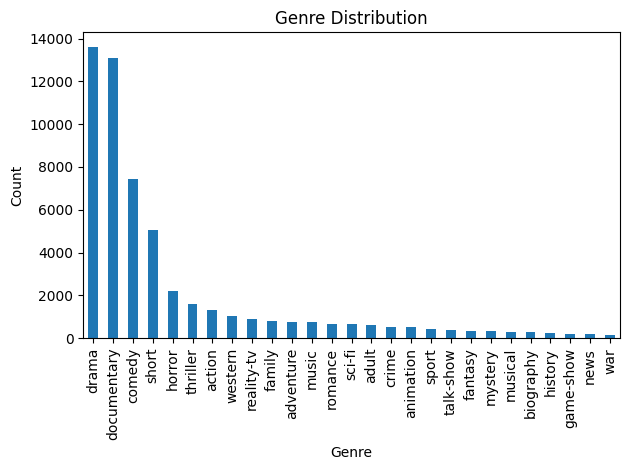

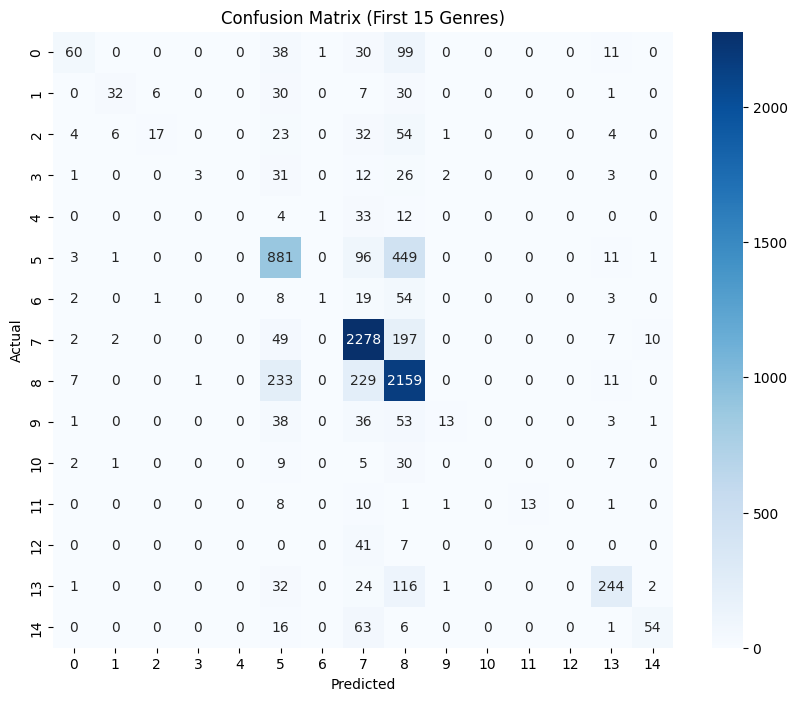

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
train_df["GENRE"].value_counts().plot(kind='bar')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Predict validation again using best model
val_pred = best_model.predict(X_valid)

cm = confusion_matrix(y_valid, val_pred)
labels = np.unique(y_valid)

plt.figure(figsize=(10,8))
sns.heatmap(cm[:15,:15], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (First 15 Genres)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
